# Урок 6. Градиентный бустинг. AdaBoost

__1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.__

In [1]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
    predictions = np.zeros(X.shape[0])
    for i, x in enumerate(X):
        prediction = 0
        for alg in trees_list:
            prediction += eta * alg.predict([x])[0]
        predictions[i] = prediction
        
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

def residual(y, z):
    return - (z - y)

def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)
    mse_train = mean_squared_error(y_train, train_prediction)
    test_prediction = gb_predict(X_test, trees, eta)
    mse_test = mean_squared_error(y_test, test_prediction)

    return mse_train, mse_test

def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()
    
# Число деревьев в ансамбле
n_trees = 10
# Максимальная глубина деревьев
max_depth = 5
# Шаг
eta = 1
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

(104.76541595487784, 7456.746926450647)

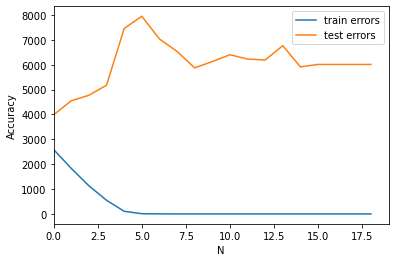

In [2]:
def get_error_plot2(train_err, test_err):
    x = list(range(0, len(train_err)))
    plt.xlim(0, len(train_err))
    plt.plot(x, train_err, label='train errors')
    plt.plot(x, test_err, label='test errors')
    plt.xlabel('N')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')

train_err = []
test_err = []

for max_depth in np.arange(1, 20, 1):
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
    mse_train, mse_test = evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)
    train_err.append(mse_train)
    test_err.append(mse_test)

get_error_plot2(train_err, test_err)

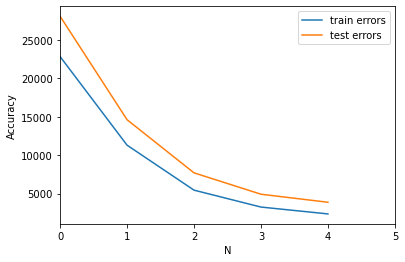

In [3]:
max_depth = 3
eta = 0.1
n_trees = [1, 5, 10, 15, 20]
train_err = []
test_err = []
train_errors = []
test_errors = []

for n_tree in n_trees:
    trees, train_errors, test_errors = gb_fit(n_tree, max_depth, X_train, X_test, y_train, y_test, eta)
    mse_train, mse_test = evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)
    train_err.append(mse_train)
    test_err.append(mse_test)

x = list(range(0, len(train_err)))
plt.xlim(0, len(train_err))
plt.plot(x, train_err, label='train errors')
plt.plot(x, test_err, label='test errors')
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.legend(loc='upper right');

__Вывод:__

1. C увеличением количества деревьев ошибка снижается как на тесте, так и на трейне.
2. С увеличением максимальной глубины дерева ошибка уменьшается на трейне и увеличивается на тесте. Возможно это связано с переобучением.

__2.* Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.__

In [4]:
def gb_fit_st(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees // 2):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

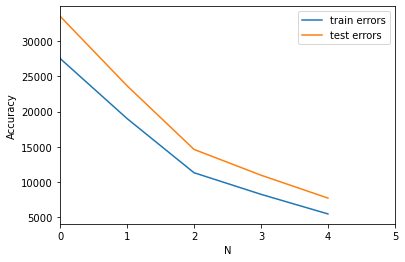

In [5]:
max_depth = 3
eta = 0.1
n_trees = [1, 5, 10, 15, 20]
train_err = []
test_err = []
train_errors = []
test_errors = []

for n_tree in n_trees:
    trees, train_errors, test_errors = gb_fit_st(n_tree, max_depth, X_train, X_test, y_train, y_test, eta)
    mse_train, mse_test = evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)
    train_err.append(mse_train)
    test_err.append(mse_test)

x = list(range(0, len(train_err)))
plt.xlim(0, len(train_err))
plt.plot(x, train_err, label='train errors')
plt.plot(x, test_err, label='test errors')
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.legend(loc='upper right');

__Вывод:__
Ошибка на стохастическом медленне снижается.